In [8]:
#Classification of MNIST dataset 
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using MLDatasets
using IterTools #Only for plots, not for program

#include("hmc_mod.jl")
#include("helper_functions.jl")
include("proposals.jl")
include("mnist.jl")
include("utils.jl");

In [9]:
#Load the MNIST Data
num_samples = 10
x_train, y_train = load_mnist_train_set()
x_test, y_test = load_mnist_test_set()

x, y = balanced_set(x_train,y_train,num_samples,2);

#Test Set
x_test, y_test = balanced_set(x_test,y_test,num_samples);

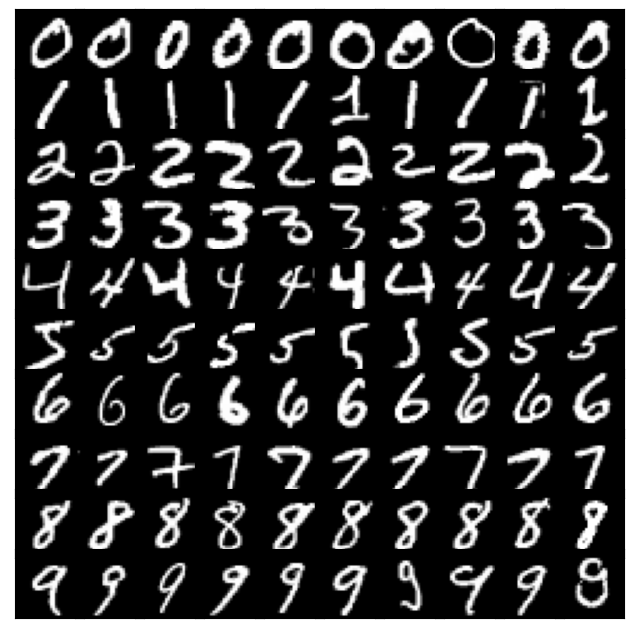

In [10]:
#Visualize Samples
x_reshaped = reshape_x(x)

nrow, ncol = 10,num_samples 
fig = figure("plot_mnist",figsize=(6,6))
for (i, (c, r)) in enumerate(Iterators.product(1:ncol, 1:nrow))
    subplot(nrow, ncol, i)
    imshow(x_reshaped[:,:,i]', cmap="gray")
    ax = gca()
    ax.xaxis.set_visible(false)
    ax.yaxis.set_visible(false)
end;
tight_layout(w_pad=-1, h_pad=-1, pad=-0.5);

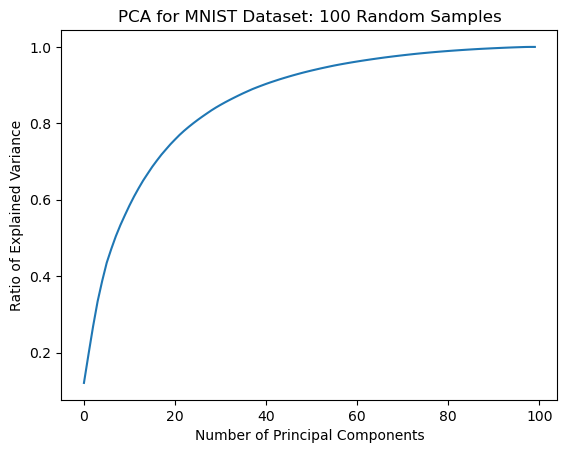

In [11]:
#Run PCA to lower dimensionality of MNIST
vars = []
x = transpose(x)
for i=1:100    
    MNIST_PCA = fit(PCA, x, maxoutdim=i, pratio=1.0)
    push!(vars,MNIST_PCA.tprinvar/MNIST_PCA.tvar)
end
plot(vars)
plt.title("PCA for MNIST Dataset: 100 Random Samples")
plt.xlabel("Number of Principal Components")
plt.ylabel("Ratio of Explained Variance");

In [12]:
#Get PCA Transform for x
dims = 25
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

#Testing PCA Transform
xz = transform(x_pca,transpose(x_test));

In [13]:
#One-Hot Encode Y
yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);

#Test Set
yz = y_test
yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);

In [14]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"

#Data hyperparameters
n = num_samples #Number of samples
c = 10 #Number of classes
d = dims #Input dimension
N = n*c #Total samples

#Network hyperparameters
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape

#Node hyperparameters
k_range = 25 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]

#NUTS
Δ_max = 1000;

In [15]:
#New Softmax
function softmax_(arr::AbstractArray)
    ex = mapslices(x -> exp.(0.1.*x),arr,dims=1)
    rows, cols = size(arr)
    val = similar(ex)
    for i in 1:cols
        s = sum(ex[:,i])
        for j in 1:rows
            val[j,i] = ex[j,i]/s
        end
    end
    return val
end;

In [16]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], c, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], c)
    
    nn_out = Dense(Wₒ, bₒ)
    x = nn_out(x)
    
    return softmax_(x)
end;

In [19]:
@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers - 1 for Classifier Net
    l ~ categorical([1.0])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    output_array = zeros(Float64, 10)
    output_array[10] = 1.0

    k[l+1] = @trace(categorical(output_array), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ##################################################
    #Adapted from BH: hyperparameter schedule - Apr 3#
    ##################################################
    
    α₁ = 1 #Input Weights, Biases Shape
    β₁ = 1 #Input Weights, Biases Scale/Rate
    α₂ = 1 #Hidden & Output Weights Shape
    β₂ = k[1] #Scale Hyperparameter Based on Number of Nodes
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])   
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(10)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)]) 
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    
    #Logistic Classification Likelihood
    y = zeros(length(scores))
    for j=1:length(x[1,:])
        score_vec = scores[:,j]
        #println(score_vec)
        y[j] = @trace(categorical(score_vec), (:y,j))
    end
    
    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(best_trace,) = generate(classifier, (xt,), obs)
println(get_score(best_trace))
println(best_trace[(:k,1)])
test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])

-2780.038453753424
16


12

In [20]:
test_labels[:,1]

10-element Array{Float64,1}:
 0.004140326959923504
 0.005806886740827344
 0.7084972017217284
 9.646990859222372e-5
 8.828663060391944e-6
 0.007283321082684634
 3.058759945726042e-10
 0.1662976345492474
 0.10164857309651835
 0.006220756971542115

In [21]:
include("proposals.jl")
obs[(:k,1)] = 1
(best_trace,) = generate(classifier, (xt,), obs)
new_trace,q = node_birth(best_trace)
display(reshape(best_trace[(:W,1)], best_trace[(:k,1)], d))
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
println(get_score(best_trace))
println(get_score(new_trace))

test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

1×25 Array{Float64,2}:
 -0.783184  0.393533  0.0750685  -0.206646  …  -1.76496  0.500905  -4.25436

2×25 Array{Float64,2}:
 -0.783184   0.393533   0.0750685  …  -1.76496   0.500905  -4.25436
 -0.478117  -1.01437   -1.0749         0.361411  1.61845   -1.70385

-314.6848277648356
-371.26155581917936
Old trace Accuracy: 12
New trace Accuracy: 14


In [22]:
include("proposals.jl")

println("Current k: $(best_trace[(:k,1)])")
new_trace2,q = node_death(new_trace)
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
display(reshape(new_trace2[(:W,1)], new_trace2[(:k,1)], d))
println(get_score(new_trace))
println(get_score(new_trace2))

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace2)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

2×25 Array{Float64,2}:
 -0.783184   0.393533   0.0750685  …  -1.76496   0.500905  -4.25436
 -0.478117  -1.01437   -1.0749         0.361411  1.61845   -1.70385

1×25 Array{Float64,2}:
 -0.478117  -1.01437  -1.0749  -1.33757  …  0.361411  1.61845  -1.70385

Current k: 1
-371.26155581917936
-312.8062842060115
Old trace Accuracy: 14
New trace Accuracy: 12


In [23]:
display(reshape(new_trace[(:W,2)],new_trace[(:k,2)],new_trace[(:k,1)]))
display(reshape(new_trace2[(:W,2)],new_trace2[(:k,2)],new_trace2[(:k,1)]))

10×2 Array{Float64,2}:
  0.696471  -0.70567
 -0.866639   0.195426
  1.25659    0.148642
 -0.361387  -0.72965
  0.821923  -0.201613
 -0.870131   0.385509
 -0.402539   0.378741
  1.19426   -0.677599
 -1.43177    0.690546
 -0.778387   0.928678

10×1 Array{Float64,2}:
 -0.7056697864592428
  0.1954258983666706
  0.14864199375776085
 -0.7296497004816386
 -0.2016128383814271
  0.3855087764995839
  0.37874062567077343
 -0.6775994314297094
  0.690546047347069
  0.9286781938573383

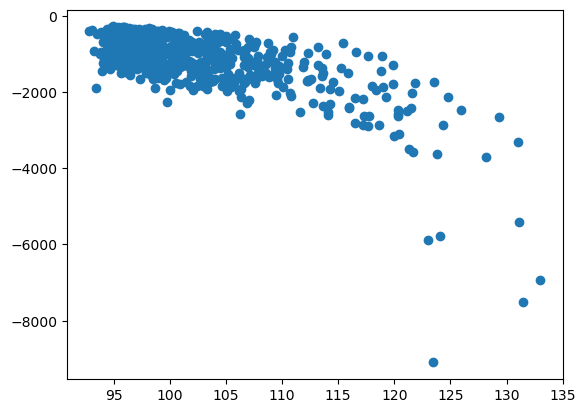

Any[20, 8, 22, 7, 23, 21, 24, 15, 20, 21, 4, 8, 11, 5, 14, 4, 25, 4, 14, 19, 19, 20, 23, 8, 14, 15, 17, 20, 23, 25, 9, 21, 8, 16, 15, 7, 21, 22, 11, 5, 1, 5, 23, 15, 18, 1, 25, 11, 19, 10, 6, 9, 8, 12, 17, 18, 18, 22, 10, 8, 17, 6, 2, 14, 25, 23, 24, 23, 12, 7, 9, 20, 5, 13, 18, 3, 25, 14, 15, 18, 4, 9, 21, 12, 2, 13, 10, 14, 22, 15, 17, 18, 14, 6, 13, 25, 6, 15, 9, 23, 24, 12, 22, 25, 20, 9, 12, 9, 22, 5, 14, 21, 21, 13, 15, 7, 11, 5, 17, 22, 14, 23, 20, 2, 23, 10, 21, 24, 18, 18, 7, 21, 4, 3, 13, 22, 7, 5, 9, 18, 20, 22, 8, 11, 13, 20, 13, 23, 14, 21, 11, 5, 9, 11, 11, 4, 13, 15, 16, 24, 10, 5, 4, 4, 1, 11, 3, 12, 7, 3, 15, 7, 20, 4, 9, 1, 2, 17, 18, 9, 12, 1, 20, 13, 23, 9, 7, 15, 2, 16, 9, 19, 25, 8, 6, 14, 23, 7, 8, 24, 3, 7, 4, 10, 2, 13, 11, 11, 16, 15, 17, 24, 22, 22, 15, 18, 24, 11, 10, 19, 8, 14, 11, 5, 14, 11, 17, 5, 18, 10, 22, 23, 16, 1, 12, 3, 22, 20, 6, 12, 3, 20, 15, 20, 17, 21, 6, 21, 12, 3, 20, 18, 16, 11, 20, 1, 8, 20, 11, 1, 25, 14, 18, 7, 11, 18, 10, 8, 9, 18, 15, 

In [25]:
#Test Likelihood
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

scores = []
accs = []
ks = []
for i = 1:1000
    (trace,) = generate(classifier, (xt,), obs)
    push!(ks,trace[(:k,1)])
    push!(scores,get_score(trace))
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_acc = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
end

scatter(accs,scores)
#plt.ylim(-2000,0)
println(ks)

In [240]:
include("NUTS.jl")
(best_trace,) = generate(classifier, (xt,), obs)
l = best_trace[:l]
param_selection = select()
for i=1:l+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end
traces = NUTS(best_trace, param_selection, 0.65, 100, 3, true);

[NUTS] start sampling for 100 samples with inital ϵ=2.0
....................................................................................................
[NUTS] sampling complete with final apated ϵ = 0.872577338055807


In [246]:
#Straight NUTS
include("NUTS.jl")
Δ_max = 100

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

m=1
iters=1000

(best_trace,) = generate(classifier, (xt,), obs)
best_k = best_trace[(:k,1)]
println("Starting ks: $best_k")
traces = []
push!(traces,best_trace)

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

for i=1:iters
    
    trace_star = traces[i]
    if i%10 == 0
        println("Iteration $i: $(get_score(trace_star))")
        flush(stdout)
    end
    trace_star = gibbs_hyperparameters(trace_star)
    trace_star, accepted = nuts_parameters(trace_star)

    push!(traces,trace_star)
end

Starting ks: 3
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 10: -405.0764261552982
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 20: -400.1047219442267
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 30: -401.24391153033116
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 40: -396.6088219510289
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 50: -397.8514402317918
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 60: -399.28661755415834
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 70: -393.17184366901347
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 80: -395.8362210286307
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 90: -406.6779129019665
Accepted
A

InterruptException: InterruptException:

In [85]:
#-------------
#Run Inference
#-------------

include("NUTS.jl")
Δ_max = 1
acc_prob = 0.65
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []

#Inference Hyperparameters
across_iters = 1
m = 2

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            #println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function node_parameter(trace)
    obs = obs_master
    for i=1:trace[:l]+1
        obs[(:τ,i)] = trace[(:τ,i)]
        obs[(:τᵦ,i)] = trace[(:τᵦ,i)]
    end
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:across_iters
        trace_tilde = gibbs_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:across_iters
        (trace_star,) = nuts_parameters(trace_star)
        trace_star = gibbs_hyperparameters(trace_star)
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[(:k,1)]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

#(trace,) = generate(classifier, (xt,), obs)
#trace = best_trace
starting_k = trace[(:k,1)]
println("Starting k: $starting_k")
traces = []

for i=1:300
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    (trace, accepted) = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    flush(stdout)
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

Starting k: 7
1 : -491.24124969888317
2 : -490.74433262878154
3 : -492.3066327958969
4 : -493.86647818467316
5 : -493.332906793144
6 : -493.23794243450715
7 : -495.23625043263456
8 : -495.7356312426327
9 : -493.98592508112125
10 : -497.6026696618487
Epoch 10 A Acceptance Probability: 0.0 %
Epoch 10 W Acceptance Probability: 70.0 %
11 : -497.67868747463797
12 : -495.92226003995324
13 : -495.4513307977659
14 : -492.26650290206925
15 : -491.65280134627517
16 : -482.7844212473622
17 : -484.7486581730655
18 : -485.9054981795187
********** Accepted: 6 **********
19 : -443.7148718848526
20 : -448.8262478905341
Epoch 20 A Acceptance Probability: 5.0 %
Epoch 20 W Acceptance Probability: 70.0 %
********** Accepted: 7 **********
21 : -475.80778611691863
22 : -478.98944721035815
23 : -478.93313589573347
24 : -479.77766691448016
********** Accepted: 6 **********
25 : -437.75551901629075
26 : -435.4514290806549
27 : -439.3974791061846
28 : -437.4712340280313
29 : -440.5603064346041
30 : -441.8695745

Epoch 220 A Acceptance Probability: 8.636363636363637 %
Epoch 220 W Acceptance Probability: 70.0 %
221 : -460.49235337353076
222 : -457.4449146309949
223 : -458.46392565098694
224 : -457.05715523559405
225 : -457.7459722223198
226 : -459.86935299486515
227 : -460.0877538250104
228 : -458.3023305399576
229 : -462.08365529252836
230 : -459.410260661563
Epoch 230 A Acceptance Probability: 8.26086956521739 %
Epoch 230 W Acceptance Probability: 70.43478260869566 %
231 : -458.8665411097442
232 : -460.11156314887853
233 : -456.1250428915465
********** Accepted: 7 **********
234 : -498.17974956059277
235 : -499.45566370407386
236 : -495.6053682636201
237 : -495.76008965508265
238 : -495.5069343436837
239 : -499.3651591917209
240 : -497.1225366261912
Epoch 240 A Acceptance Probability: 8.333333333333332 %
Epoch 240 W Acceptance Probability: 70.0 %
241 : -496.3074748221944
242 : -498.3119401224013
243 : -500.31530965337606
********** Accepted: 8 **********
244 : -542.030256658287
245 : -541.8756

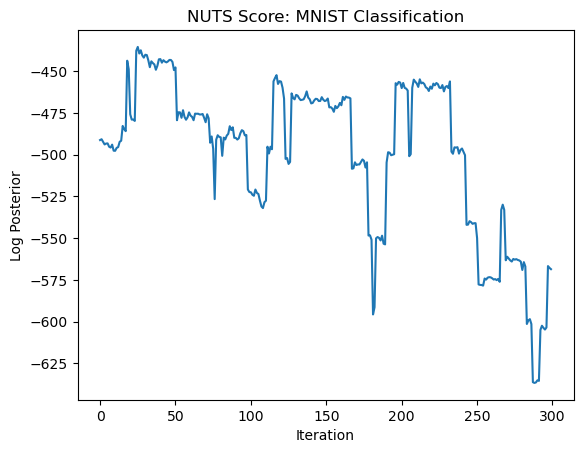

In [86]:
#Log Posterior Score Chart
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: MNIST Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

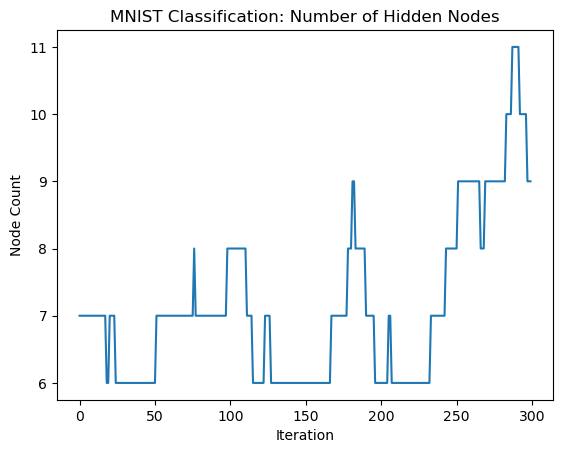

In [87]:
#Node Count Chart

plot([trace[(:k,1)] for trace in traces])
plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Iteration")
plt.ylabel("Node Count");

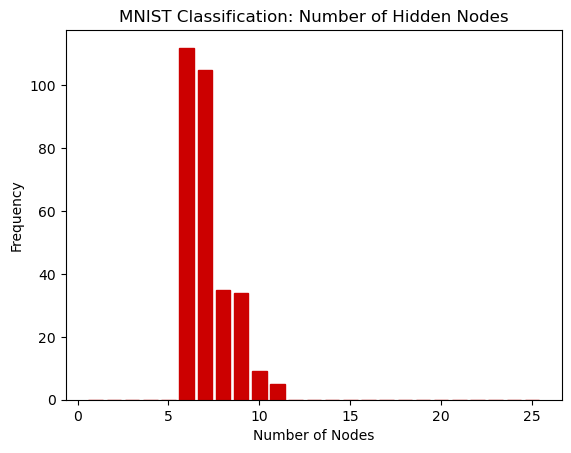

In [119]:
#Node Count Histogram

########################
#Bar Plot of l estimates
########################

ks = [traces[i][(:k,1)] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]

barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
#barlist[2].set_color([0.0,0.8,0.1])

plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency");

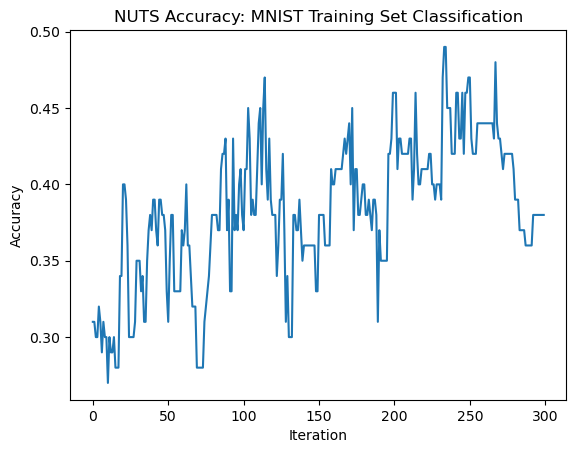

In [89]:
#Plot Training Accuracy
accs = []
dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Training Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

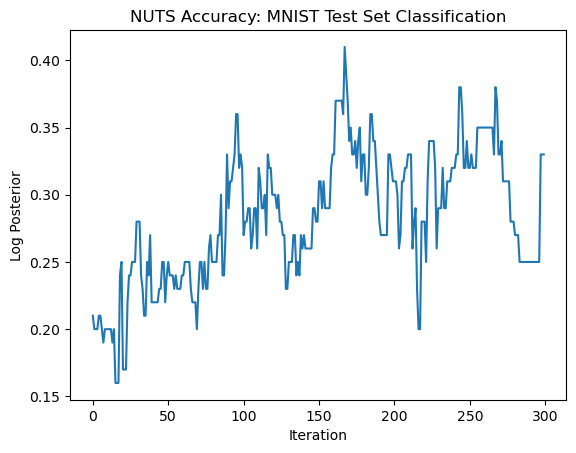

In [90]:
#Plot Testing Accuracy
accs = []
#dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xz,trace)
    results = label_output(test_labels)
    test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
    test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    #push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

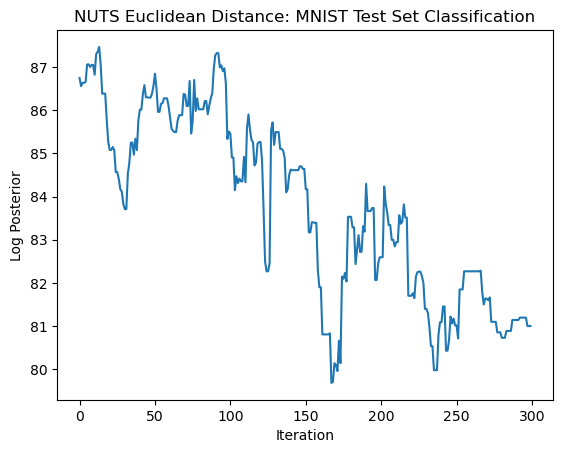

In [91]:
plot(dists)
plt.title("NUTS Euclidean Distance: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

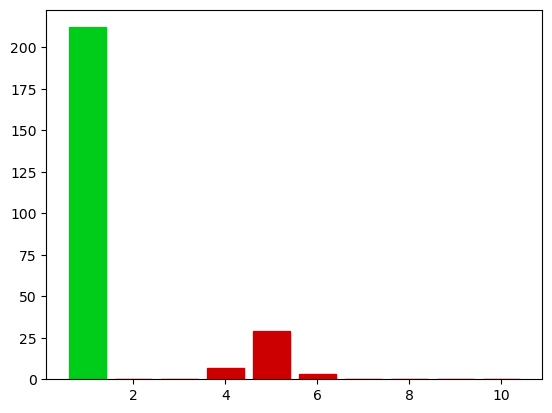

Any[5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 1, 6, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1


In [118]:
#Bar Chart of Guesses For Given Target
targets = []
target = 2
for i=50:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    push!(targets,results[target])
end
#counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
counts = [sum([targets[i] == j for i in 1:length(targets)]) for j in 1:10]

barlist=bar(1:10,counts)
for i in 1:10
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[y[target]].set_color([0.0,0.8,0.1])
println(targets)
println(y[target])

In [93]:
#Marginalize Probabilities - Train Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xt,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])

55

In [94]:
#Marginalize Probabilities - Test Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xz,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([yz[i] == guesses[i] for i=1:length(yz)])

40